# 32 context.Context类型
我们在上篇文章中讲到了`sync.WaitGroup`类型：一个可以帮我们实现一对多`goroutine`协作流程的同步工具。

**在使用`WaitGroup`值的时候，我们最好用“先统一`Add`，再并发`Done`，最后`Wait`”的标准模式来构建协作流程。**

如果在调用该值的`Wait`方法的同时，为了增大其计数器的值，而并发地调用该值的`Add`方法，那么就很可能会引发`panic`。

这就带来了一个问题，如果我们不能在一开始就确定执行子任务的`goroutine`的数量，那么使用`WaitGroup`值来协调它们和分发子任务的`goroutine`，就是有一定风险的。一个解决方案是：**分批地启用执行子任务的`goroutine`**。

## 前导内容：WaitGroup值补充知识
我们都知道，`WaitGroup`值是可以被复用的，但需要保证其计数周期的完整性。尤其是涉及对其`Wait`方法调用的时候，它的下一个计数周期必须要等到，与当前计数周期对应的那个`Wait`方法调用完成之后，才能够开始。

我在前面提到的可能会引发`panic`的情况，就是由于没有遵循这条规则而导致的。

只要我们在严格遵循上述规则的前提下，分批地启用执行子任务的`goroutine`，就肯定不会有问题。具体的实现方式有不少，其中最简单的方式就是使用for循环来作为辅助。这里的代码如下：

In [ ]:
func coordinateWithWaitGroup() {
 total := 12
 stride := 3
 var num int32
 fmt.Printf("The number: %d [with sync.WaitGroup]\n", num)
 var wg sync.WaitGroup
 for i := 1; i <= total; i = i + stride {
  wg.Add(stride)
  for j := 0; j < stride; j++ {
   go addNum(&num, i+j, wg.Done)
  }
  wg.Wait()
 }
 fmt.Println("End.")
}

这里展示的`coordinateWithWaitGroup`函数，就是上一篇文章中同名函数的改造版本。而其中调用的`addNum`函数，则是上一篇文章中同名函数的简化版本。这两个函数都已被放置在了demo67.go文件中。

我们可以看到，经过改造后的`coordinateWithWaitGroup`函数，循环地使用了由变量`wg`代表的`WaitGroup`值。**它运用的依然是“先统一Add，再并发Done，最后Wait”的这种模式，只不过它利用for语句，对此进行了复用**。

好了，至此你应该已经对`WaitGroup`值的运用有所了解了。不过，我现在想让你使用另一种工具来实现上面的协作流程。

**我们今天的问题就是：怎样使用`context`包中的程序实体，实现一对多的`goroutine`协作流程？**

更具体地说，我需要你编写一个名为`coordinateWithContext`的函数。这个函数应该具有上面`coordinateWithWaitGroup`函数相同的功能。

显然，你不能再使用`sync.WaitGroup`了，而要用`context`包中的函数和`Context`类型作为实现工具。这里注意一点，是否分批启用执行子任务的`goroutine`其实并不重要。

我在这里给你一个参考答案。

In [ ]:
func coordinateWithContext() {
 total := 12
 var num int32
 fmt.Printf("The number: %d [with context.Context]\n", num)
 cxt, cancelFunc := context.WithCancel(context.Background())
 for i := 1; i <= total; i++ {
  go addNum(&num, i, func() {
   if atomic.LoadInt32(&num) == int32(total) {
    cancelFunc()
   }
  })
 }
 <-cxt.Done()
 fmt.Println("End.")
}

在这个函数体中，我先后调用了`context.Background`函数和`context.WithCancel`函数，并得到了一个可撤销的`context.Context`类型的值（由变量cxt代表），以及一个`context.CancelFunc`类型的撤销函数（由变量`cancelFunc`代表）。

在后面那条唯一的for语句中，我在每次迭代中都通过一条go语句，异步地调用`addNum`函数，调用的总次数只依据了`total`变量的值。

请注意我给予`addNum`函数的最后一个参数值。它是一个匿名函数，其中只包含了一条`if`语句。这条`if`语句会“原子地”加载`num`变量的值，并判断它是否等于`total`变量的值。

如果两个值相等，那么就调用`cancelFunc`函数。**其含义是，如果所有的`addNum`函数都执行完毕，那么就立即通知分发子任务的`goroutine`。**

这里分发子任务的`goroutine`，即为执行`coordinateWithContext`函数的`goroutine`。它在执行完`for`语句后，会立即调用`cxt`变量的`Done`函数，并试图针对该函数返回的通道，进行接收操作。

由于一旦`cancelFunc`函数被调用，针对该通道的接收操作就会马上结束，所以，这样做就可以实现“等待所有的`addNum`函数都执行完毕”的功能。

## 问题解析

`context.Context`类型（以下简称Context类型）是在Go 1.7发布时才被加入到标准库的。而后，标准库中的很多其他代码包都为了支持它而进行了扩展，包括：`os/exec包、net包、database/sql包，以及runtime/pprof包和runtime/trace包`，等等。

`Context`类型之所以受到了标准库中众多代码包的积极支持，**主要是因为它是一种非常通用的同步工具。它的值不但可以被任意地扩散，而且还可以被用来传递额外的信息和信号。**

更具体地说，`Context`类型可以提供一类代表上下文的值。此类值是**并发安全**的，也就是说它可以被传播给多个`goroutine`。

由于`Context`类型实际上是一个**接口**类型，而`context`包中实现该接口的所有私有类型，都是基于某个数据类型的指针类型，所以，如此传播并不会影响该类型值的功能和安全。

`Context`类型的值（以下简称`Context`值）是可以繁衍的，这意味着我们可以通过一个`Context`值产生出任意个子值。这些子值可以携带其父值的属性和数据，也可以响应我们通过其父值传达的信号。

正因为如此，所有的`Context`值共同构成了一颗代表了上下文全貌的**树形结构**。这棵树的树根（或者称上下文根节点）是一个已经在`context`包中预定义好的`Context`值，它是全局唯一的。通过调用`context.Background`函数，我们就可以获取到它（我在`coordinateWithContext`函数中就是这么做的）。

这里注意一下，这个上下文根节点仅仅是一个最基本的支点，它不提供任何额外的功能。也就是说，**它既不可以被撤销（cancel），也不能携带任何数据**。

除此之外，`context`包中还包含了四个用于繁衍`Context`值的函数，即：`WithCancel`、`WithDeadline`、`WithTimeout`和`WithValue`。

这些函数的第一个参数的类型都是`context.Context`，而名称都为`parent`。顾名思义，这个位置上的参数对应的都是它们将会产生的`Context`值的父值。

`WithCancel`函数用于产生一个可撤销的`parent`的子值。在`coordinateWithContext`函数中，我通过调用该函数，获得了一个衍生自上下文根节点的`Context`值，和一个用于触发撤销信号的函数。

而`WithDeadline`函数和`WithTimeout`函数则都可以被用来产生一个会定时撤销的`parent`的子值。至于`WithValue`函数，我们可以通过调用它，产生一个会携带额外数据的`parent`的子值。

到这里，我们已经对`context`包中的函数和`Context`类型有了一个基本的认识了。不过这还不够，我们再来扩展一下。

## 知识扩展
**问题1：“可撤销的”在`context`包中代表着什么？“撤销”一个`Context`值又意味着什么？**
我相信很多初识`context`包的`Go`程序开发者，都会有这样的疑问。确实，“可撤销的”（cancelable）这个词在这里是比较抽象的，很容易让人迷惑。我这里再来解释一下。

这需要从`Context`类型的声明讲起。这个接口中有两个方法与“撤销”息息相关。`Done`方法会返回一个元素类型为struct{}的接收通道。不过，这个接收通道的用途并不是传递元素值，而是让调用方去感知“撤销”当前`Context`值的那个信号。

一旦当前的`Context`值被撤销，这里的接收通道就会被立即关闭。我们都知道，对于一个未包含任何元素值的通道来说，**它的关闭会使任何针对它的接收操作立即结束。**

正因为如此，在`coordinateWithContext`函数中，基于调用表达式`cxt.Done()`的接收操作，才能够起到感知撤销信号的作用。

除了让`Context`值的使用方感知到撤销信号，让它们得到“撤销”的具体原因，有时也是很有必要的。后者即是`Context`类型的`Err`方法的作用。该方法的结果是`error`类型的，并且其值只可能等于`context.Canceled`变量的值，或者`context.DeadlineExceeded`变量的值。

**前者用于表示手动撤销，而后者则代表：由于我们给定的过期时间已到，而导致的撤销。**

你可能已经感觉到了，对于`Context`值来说，“撤销”这个词如果当名词讲，指的其实就是被用来表达“撤销”状态的信号；如果当动词讲，指的就是对撤销信号的传达；而“可撤销的”指的则是具有传达这种撤销信号的能力。

我在前面讲过，当我们通过调用`context.WithCancel`函数产生一个可撤销的`Context`值时，还会获得一个用于触发撤销信号的函数。

通过调用这个函数，我们就可以触发针对这个`Context`值的撤销信号。一旦触发，撤销信号就会立即被传达给这个`Context`值，并由它的`Done`方法的结果值（一个接收通道）表达出来。

撤销函数只负责触发信号，而对应的可撤销的`Context`值也只负责传达信号，它们都不会去管后边具体的“撤销”操作。实际上，我们的代码可以在感知到撤销信号之后，进行任意的操作，`Context`值对此并没有任何的约束。

最后，若再深究的话，这里的“撤销”最原始的含义其实就是，终止程序针对某种请求（比如HTTP请求）的响应，或者取消对某种指令（比如SQL指令）的处理。这也是Go语言团队在创建`context`代码包，和`Context`类型时的初衷。

如果我们去查看`net`包和`database/sql`包的API和源码的话，就可以了解它们在这方面的典型应用。

**问题2：撤销信号是如何在上下文树中传播的？**
我在前面讲了，context包中包含了四个用于繁衍Context值的函数。其中的WithCancel、WithDeadline和WithTimeout都是被用来基于给定的Context值产生可撤销的子值的。

context包的WithCancel函数在被调用后会产生两个结果值。第一个结果值就是那个可撤销的Context值，而第二个结果值则是用于触发撤销信号的函数。

在撤销函数被调用之后，对应的Context值会先关闭它内部的接收通道，也就是它的Done方法会返回的那个通道。

然后，它会向它的所有子值（或者说子节点）传达撤销信号。这些子值会如法炮制，把撤销信号继续传播下去。最后，这个Context值会断开它与其父值之间的关联。
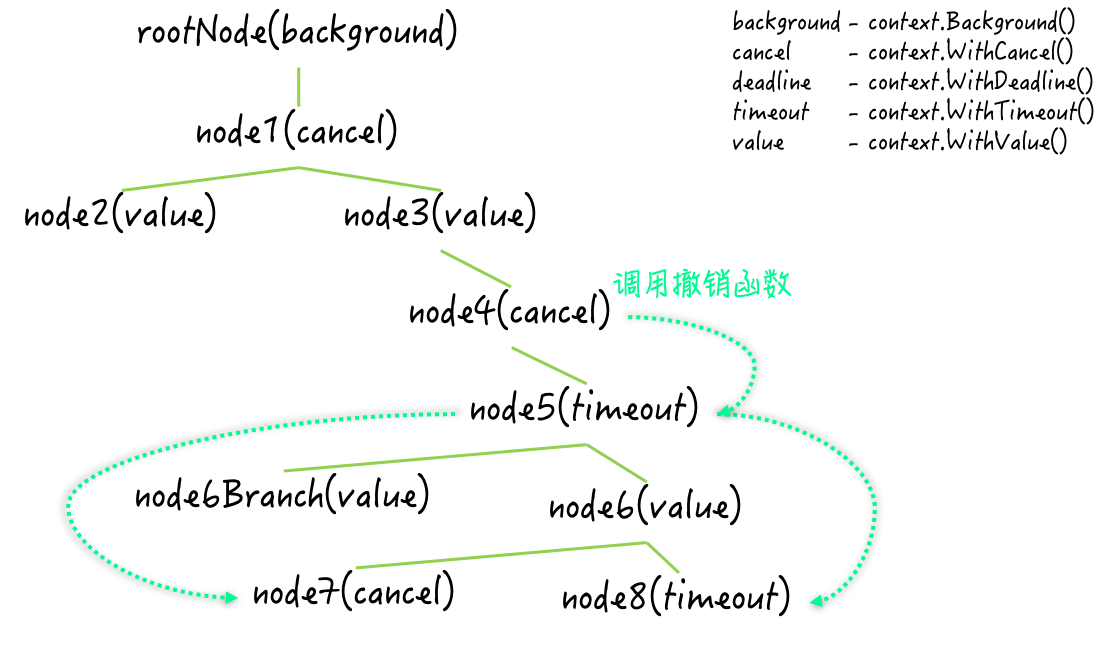

我们通过调用`context`包的`WithDeadline`函数或者`WithTimeout`函数生成的`Context`值也是可撤销的。它们不但可以被手动撤销，还会依据在生成时被给定的过期时间，自动地进行定时撤销。这里定时撤销的功能是借助它们内部的计时器来实现的。

当过期时间到达时，这两种`Context`值的行为与`Context`值被手动撤销时的行为是几乎一致的，只不过前者会在最后停止并释放掉其内部的计时器。

最后要注意，**通过调用`context.WithValue`函数得到的`Context`值是不可撤销的**。撤销信号在被传播时，若遇到它们则会直接跨过，并试图将信号直接传给它们的子值。

**问题 3：怎样通过Context值携带数据？怎样从中获取数据？**
既然谈到了`context`包的`WithValue`函数，我们就来说说`Context`值携带数据的方式。

`WithValue`函数在产生新的`Context`值（以下简称含数据的Context值）的时候需要三个参数，即：父值、键和值。与“字典对于键的约束”类似，这里键的类型必须是可判等的。

原因很简单，当我们从中获取数据的时候，它需要根据给定的键来查找对应的值。不过，这种`Context`值并不是用字典来存储键和值的，后两者只是被简单地存储在前者的相应字段中而已。

`Context`类型的`Value`方法就是被用来获取数据的。在我们调用含数据的`Context`值的`Value`方法时，它会先判断给定的键，是否与当前值中存储的键相等，如果相等就把该值中存储的值直接返回，否则就到其父值中继续查找。

如果其父值中仍然未存储相等的键，那么该方法就会沿着上下文根节点的方向一路查找下去。

注意，除了含数据的`Context`值以外，其他几种`Context`值都是无法携带数据的。因此，`Context`值的`Value`方法在沿路查找的时候，会直接跨过那几种值。

如果我们调用的`Value`方法的所属值本身就是不含数据的，那么实际调用的就将会是其父辈或祖辈的`Value`方法。这是由于这几种`Context`值的实际类型，都属于结构体类型，并且它们都是通过“将其父值嵌入到自身”，来表达父子关系的。

最后，提醒一下，`Context`接口并没有提供改变数据的方法。因此，在通常情况下，我们只能通过在上下文树中添加含数据的`Context`值来存储新的数据，或者通过撤销此种值的父值丢弃掉相应的数据。如果你存储在这里的数据可以从外部改变，那么必须自行保证安全。

## 总结
我们今天主要讨论的是`context`包中的函数和`Context`类型。该包中的函数都是用于产生新的`Context`类型值的。`Context`类型是一个可以帮助我们实现多`goroutine`协作流程的同步工具。不但如此，我们还可以通过此类型的值传达撤销信号或传递数据。

`Context`类型的实际值大体上分为三种，即：根`Context`值、可撤销的`Context`值和含数据的`Context`值。所有的`Context`值共同构成了一颗上下文树。这棵树的作用域是全局的，而根`Context`值就是这棵树的根。它是全局唯一的，并且不提供任何额外的功能。

可撤销的`Context`值又分为：只可手动撤销的`Context`值，和可以定时撤销的`Context`值。

我们可以通过生成它们时得到的撤销函数来对其进行手动的撤销。对于后者，定时撤销的时间必须在生成时就完全确定，并且不能更改。不过，我们可以在过期时间达到之前，对其进行手动的撤销。

一旦撤销函数被调用，撤销信号就会立即被传达给对应的`Context`值，并由该值的`Done`方法返回的接收通道表达出来。

“撤销”这个操作是`Context`值能够协调多个`goroutine`的关键所在。撤销信号总是会沿着上下文树叶子节点的方向传播开来。

含数据的`Context`值可以携带数据。每个值都可以存储一对键和值。在我们调用它的`Value`方法的时候，它会沿着上下文树的根节点的方向逐个值的进行查找。如果发现相等的键，它就会立即返回对应的值，否则将在最后返回nil。

含数据的`Context`值不能被撤销，而可撤销的`Context`值又无法携带数据。但是，由于它们共同组成了一个有机的整体（即上下文树），所以在功能上要比`sync.WaitGroup`强大得多。

## 思考题
今天的思考题是：Context值在传达撤销信号的时候是广度优先的，还是深度优先的？其优势和劣势都是什么？

它是深度优先的。其优势和劣势都是：直接分支的产生时间越早，其中的所有子节点就会越先接收到信号。至于什么时候是优势、什么时候是劣势还要看具体的应用场景。

例如，如果子节点的存续时间与资源的消耗是正相关的，那么这可能就是一个优势。但是，如果每个分支中的子节点都很多，而且各个分支中的子节点的产生顺序并不依从于分支的产生顺序，那么这种优势就很可能会变成劣势。最终的定论还是要看测试的结果。